# Normative Modelling: Hierarchical Bayesian Regression with Beta likelihood

Welcome to this tutorial notebook that will go through the fitting and evaluation of Normative models with a Hierarchical Bayesian Regression model using a Beta likelihood. 

Let's jump right in.

### Imports

In [1]:
import warnings
import logging


import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit import (
    HBR,
    BsplineBasisFunction,
    NormativeModel,
    NormData,
    load_fcon1000,
    BetaLikelihood,
    make_prior,
    plot_centiles,
    plot_qq,
    plot_ridge,
)

import numpy as np
import pcntoolkit.util.output
import seaborn as sns
import os

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)

## Load data

First we download a small example dataset from github.

In [2]:
# Download an example dataset
norm_data: NormData = load_fcon1000()

# Select only a few features
features_to_model = [
    "WM-hypointensities",
    "Right-Lateral-Ventricle",
    "Right-Amygdala",
    "CortexVol",
]
norm_data = norm_data.sel({"response_vars": features_to_model})

# Split into train and test sets
train, test = norm_data.train_test_split()


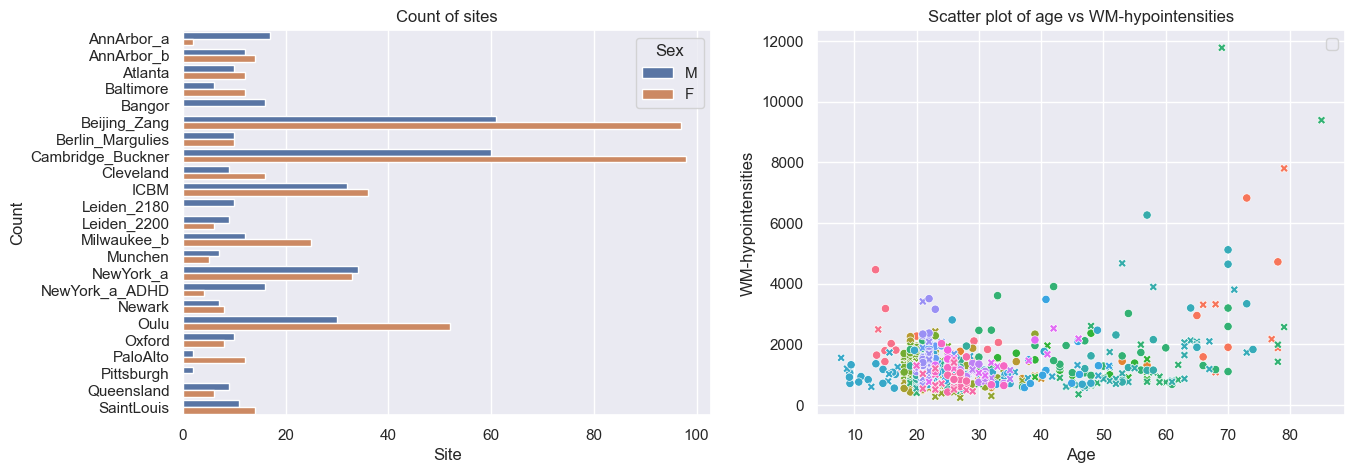

In [3]:
# Visualize the data
feature_to_plot = features_to_model[0]
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")


sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

## Creating a Normative model

A normative model has a regression model for each response variable. We provide a template regression model which is copied for each response variable. 

A template regression model can be anything that extends the `RegressionModel`. We provide a number of built-in regression models, but you can also create your own. 

Here we use the `HBR` class, which implements a Hierarchical Bayesian Regression model. 


### Likelihoods

`HBR` models are composed of a likelihood and a number of priors on the parameters of the likelihood. The PCNtoolkit offers a number of likelihood functions:
1. NormallLikelihood: Good for modeling data that is (approximately) normally distributed.
2. SHASHbLikelihood: Good for modeling data that is heavily skewed, or tailed. 
3. BetaLikelihood: Good for modeling data that is bounded, e.g. between 0 and 1.

### Likelihood parameters

Each of these likelihoods takes their own set of parameters, and for each, we have to set a prior:
1. NormalLikelihood:
    - `mu`: The mean of the normal distribution.
    - `sigma`: The standard deviation of the normal distribution.
2. SHASHbLikelihood:
    - `mu`: The mean of the skew-normal distribution.
    - `sigma`: The standard deviation of the skew-normal distribution.
    - `epsilon`: The skewness parameter of the skew-normal distribution.
    - `delta`: The tail thickness (or kurtosis) of the skew-normal distribution.
3. BetaLikelihood:
    - `alpha`: The shape parameter of the beta distribution.
    - `beta`: The scale parameter of the beta distribution.

### Configuring likelihood parameters

Each likelihood parameter needs to be configured. The defaults should work reasonably well for most cases, at least where the data is standardized. Here's a quick guide to configuring the likelihood parameters yourself, using the `make_prior` function.

1. Is your parameter a function of the covariates? If so, you set the `linear` parameter to `True`.
   1. If so, you can choose the basis expansion to use for the parameter: BSplineBasisFunction, LinearBasisFunction, or PolynomialBasisFunction.
   2. Also, determine whether the slope and intercept of the prior have a random effect or not. Here's an example of a linear prior with a bspline basis expansion and a random effect in the intercept. 

```python
mu = make_prior('mu', linear=True, basis_function=BSplineBasisFunction(degree=3, nknots=5), intercept = make_prior('intercept_mu', random=True))
```

2. If your parameter is not a function of the covariates, you have to decide whether the parameter itself has a random effect or not. Here's an example of a prior with a random effect.

```python
epsilon = make_prior('epsilon', random=True)
```

3. Some parameters (such as sigma) need to be strictly positive, which we can enforce with a mapping. Here's an example of a prior with a mapping to the positive real line.

```python
# The mapping_params are (horizontal shift, scaling, vertical shift)
sigma = make_prior('sigma', mapping='softplus', mapping_params=(0, 5, 0))
```

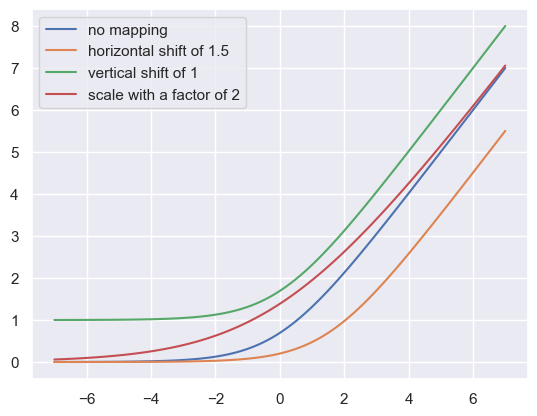

In [4]:
# Mini demo of the mapping params
xsp = np.linspace(-7, 7, 100)
softplus = lambda x: np.log(1 + np.exp(x))
paramaterized_softplus = lambda x, a, b, c: softplus((x - a) / b) * b + c
plt.plot(xsp, paramaterized_softplus(xsp, 0, 1, 0), label="no mapping")
plt.plot(xsp, paramaterized_softplus(xsp, 1.5, 1, 0), label="horizontal shift of 1.5")
plt.plot(xsp, paramaterized_softplus(xsp, 0, 1, 1), label="vertical shift of 1")
plt.plot(xsp, paramaterized_softplus(xsp, 0, 2, 0), label="scale with a factor of 2")
plt.legend()
plt.show()


4. Any non-linear parameters can be further configured with `dist_name` and `dist_params`. Here's an example of a prior with a gamma distribution. 

```python
alpha = make_prior('alpha', dist_name='gamma', dist_params=(1, 1))
```
We currently support the following distributions:
- Normal
- HalfNormal
- LogNormal
- Uniform
- Gamma
  
The order of the parameters is important, and follows the order of the parameters in the corresponding distributions in PyMC.


### Creating a HBR model

Here's a thoroughly commented example of a HBR model with a BetaLikelihood, which we will use to model our response variable.

In [5]:
# The beta likelihood is a bit different from the other likelihoods, it assumes the response variable is bounded between 0 and 1. The means that we have to apply a min max scaling to the response variable before fitting the model. Luckily, this is built into the PCNtoolkit, we just have to set 'outscaler' to 'minmax' in the `NormativeModel` constructor.

# The beta likelihood takes two parameters, alpha and beta. Intuitively, these encode 'pseudo-counts'.
# alpha=2, beta=4 encodes a distribution with a weak peak at 1/3.
# alpha=4, beta=8 encodes a distribution with a stronger peak at 1/3.
# alpha=20, beta=40 encodes a distribution with a very strong peak at 1/3.

# Alpha and beta both need to be strictly positive, so we either have to sample them from a positive distribution, or apply a mapping.

# A model where alpha and beta are both linear functions of the covariates, and the intercepts for both alpha and beta are random
alpha = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(10.0, 3.0)),
        sigma=make_prior(dist_name="Normal", dist_params=(0.0, 3.0), mapping="softplus", mapping_params=(0.0, 3.0)),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
beta = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(10.0, 3.0)),
        sigma=make_prior(dist_name="Normal", dist_params=(0.0, 3.0), mapping="softplus", mapping_params=(0.0, 3.0)),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)


beta_likelihood = BetaLikelihood(alpha, beta)

beta_HBR_model = HBR(
    name="beta_HBR_model",
    likelihood=beta_likelihood,
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
)


After specifying the regression model, we can configure a normative model. 

A normative model has a number of configuration options:
- `savemodel`: Whether to save the model after fitting.
- `evaluate_model`: Whether to evaluate the model after fitting.
- `saveresults`: Whether to save the results after evaluation.
- `saveplots`: Whether to save the plots after fitting.
- `save_dir`: The directory to save the model, results, and plots.
- `inscaler`: The scaler to use for the input data.
- `outscaler`: The scaler to use for the output data.




In [6]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=beta_HBR_model,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=False,
    # The directory to save the model, results, and plots.
    save_dir="resources/hbr_beta/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="minmax",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="minmax",
)

## Fit the model


With all that configured, we can fit the model. 

The `fit_predict` function will fit the model, evaluate it, and save the results and plots (if so configured). 

After that, it will compute Z-scores and centiles for the test set. 

All results can be found in the save directory. 

In [7]:
model.fit_predict(train, test)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,2,0.14,63
,2000,1,0.12,63
,2000,1,0.12,63
,2000,1,0.12,63


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,3,0.13,95
,2000,13,0.13,31
,2000,10,0.13,127
,2000,5,0.13,127


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,127
,2000,0,0.13,127
,2000,2,0.12,63
,2000,0,0.12,255


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,9,0.13,127
,2000,4,0.12,127
,2000,1,0.12,63
,2000,8,0.12,63


<xarray.NormData> Size: 98kB
Dimensions:            (observations: 216, response_vars: 4, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 11)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U23 368B 'WM-hypointensities' ... 'Co...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 2kB 'Munchen_sub96752' ... 'Quee...
    Y                  (observations, response_vars) float64 7kB 2.721e+03 .....
    X                  (observations, covariates) float64 2kB 63.0 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 7kB 0.5534 ... -...
    centiles           (centile, observations, response_vars) float64 35kB 90...
    logp               (observations, response_vars) float64 7kB 1.186 ... 0....
    Yhat               (observations, response_vars) float64 7kB 2.274e+03 .....
    statistics         (response_vars, statistic) float64 352B -0.4647 ... nan
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {np.str_('sex'): [np.str_('F'), np.str_('...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'min': np.float64(7.88)...
    batch_effect_covariate_ranges:  {np.str_('sex'): {np.str_('F'): {np.str_(...

## Plot the results

The PCNtoolkit offers are a number of different plotting functions:
1. plot_centiles: Plot the predicted centiles for a model
2. plot_qq: Plot the QQ-plot of the predicted Z-scores
3. plot_ridge: Plot density plots of the predicted Z-scores

Let's start with the centiles.

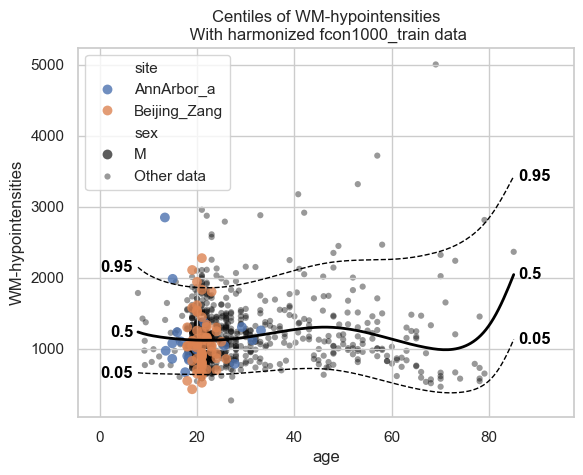

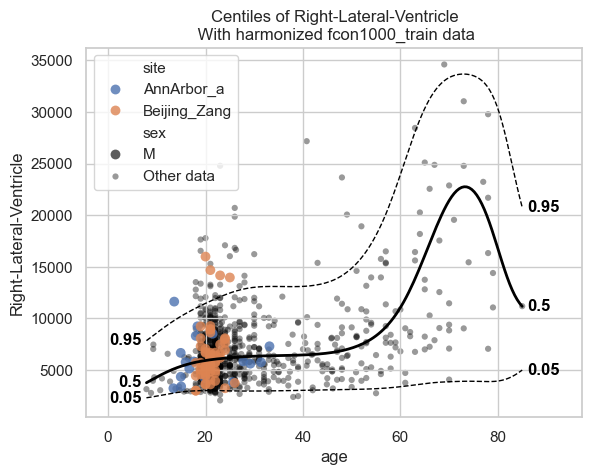

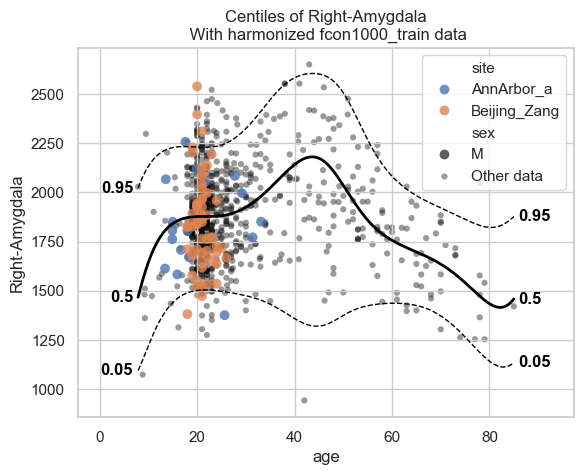

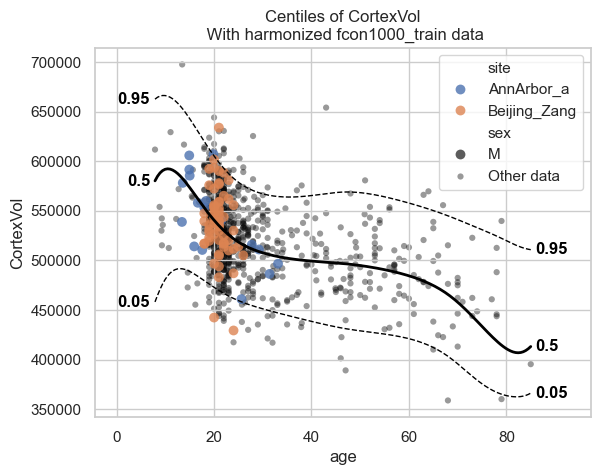

In [8]:
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=train,  # Scatter this data along with the centiles
    batch_effects={"site": ["Beijing_Zang", "AnnArbor_a"], "sex": ["M"]},  # Highlight these groups
    show_other_data=True,  # scatter data not in those groups as smaller black circles
    harmonize=True,  # harmonize the scatterdata, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
)

Now let's see the qq plots

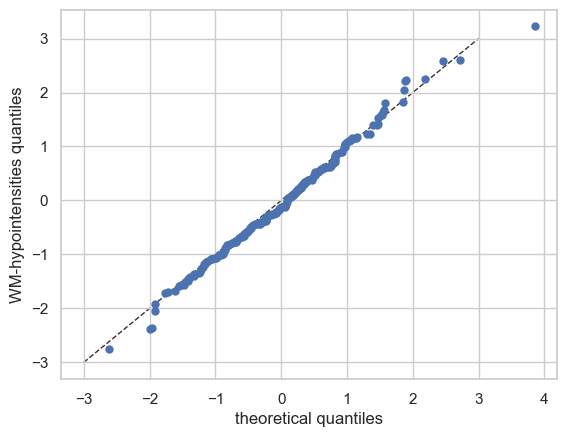

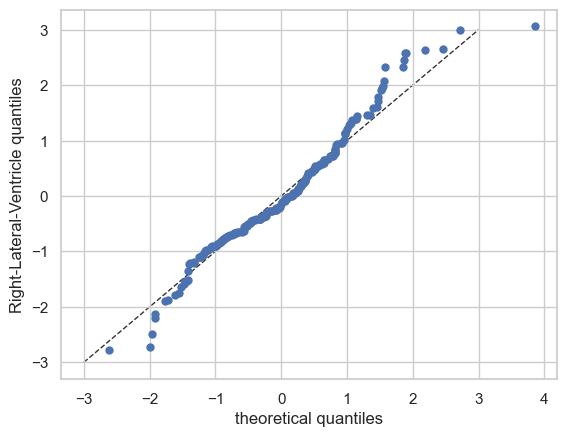

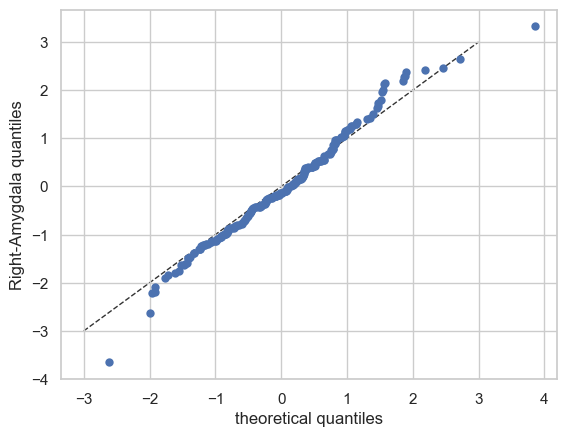

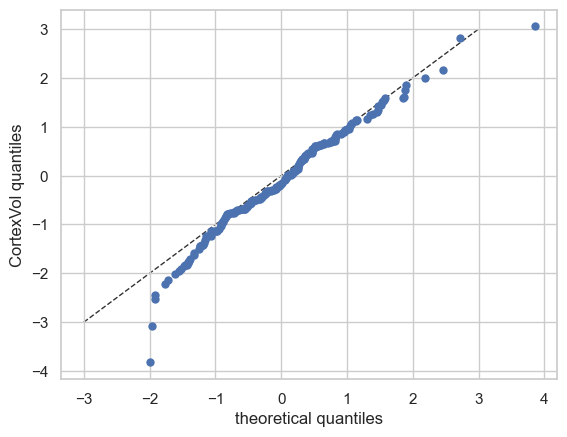

In [9]:
plot_qq(test, plot_id_line=True)

We can also split the QQ plots by batch effects:

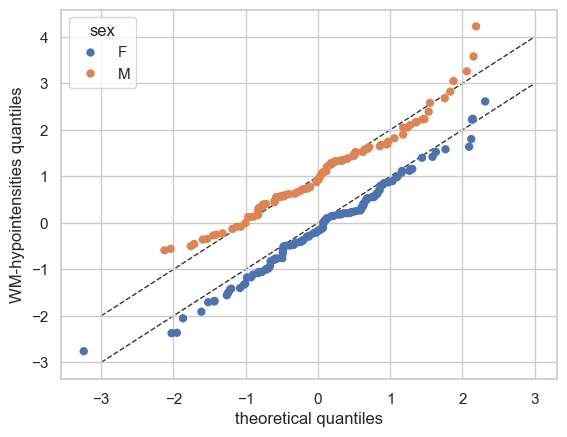

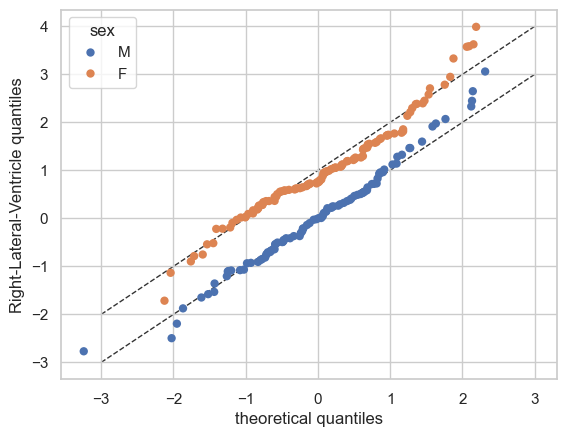

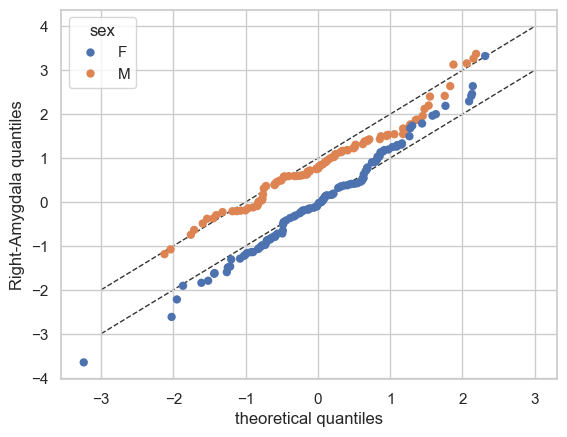

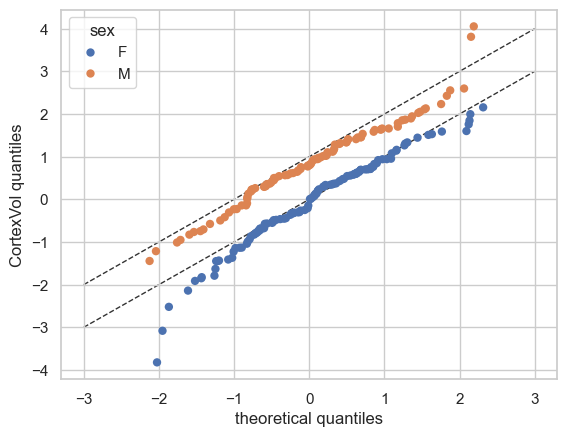

In [10]:
plot_qq(test, plot_id_line=True, hue_data="sex", split_data="sex")
sns.set_theme(style="darkgrid", rc={"axes.facecolor": (0, 0, 0, 0)})

And finally the ridge plot:

/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args,

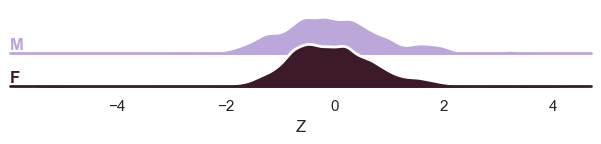

/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args,

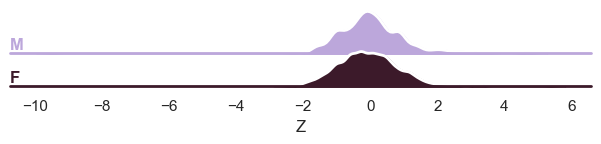

/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args,

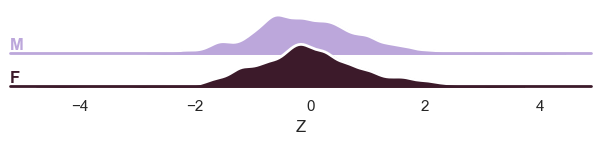

/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/ptk/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args,

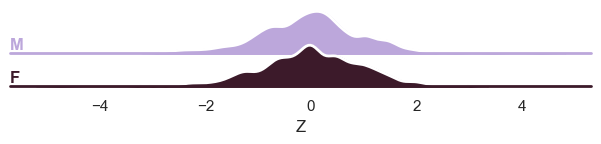

In [11]:
plot_ridge(
    train, "Z", split_by="sex"
)  # We can also show the 'Y' variable, and that will show the marginal distribution of the response variable, per batch effect.

Evaluation statistcs are stored in the NormData object:

In [12]:
display(train.get_statistics_df())
display(test.get_statistics_df())

statistic,EXPV,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,,
CortexVol,0.48,0.01,1.678856e+11,0.36,-0.83,0.48,0.11,0.70,0.0,0.52,NaN
Right-Amygdala,0.39,0.02,2.844913e+09,0.25,-0.77,0.39,0.11,0.60,0.0,0.61,NaN
Right-Lateral-Ventricle,0.16,0.03,5.096293e+10,0.36,-1.08,0.16,0.11,0.39,0.0,0.84,0.92
WM-hypointensities,0.02,0.03,3.433962e+09,0.76,-1.99,0.01,0.07,0.52,0.0,0.99,0.97


statistic,EXPV,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,,
CortexVol,0.36,0.02,0.33,-inf,inf,0.35,0.11,0.64,0.0,0.65,NaN
Right-Amygdala,0.25,0.02,0.35,0.09,-0.65,0.24,0.12,0.50,0.0,0.76,0.99
Right-Lateral-Ventricle,0.11,0.02,1.06,0.29,-0.99,0.11,0.11,0.27,0.0,0.89,0.98
WM-hypointensities,-0.46,0.02,0.60,0.39,-1.91,-0.50,0.06,0.46,0.0,1.50,0.99


## What's next?

Now we have a normative hierarchical Bayesian regression model, we can use it to:

- Make predictions on new data
- Harmonize data, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
- Synthesize new data
- Extend the model using data from new batches

### Predicting

In [14]:
model.predict(test)

<xarray.NormData> Size: 98kB
Dimensions:            (observations: 216, response_vars: 4, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 10)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U23 368B 'WM-hypointensities' ... 'Co...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 320B 'MACE' 'MAPE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 2kB 'Munchen_sub96752' ... 'Quee...
    Y                  (observations, response_vars) float64 7kB 2.721e+03 .....
    X                  (observations, covariates) float64 2kB 63.0 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 7kB 0.5558 ... -...
    centiles           (centile, observations, response_vars) float64 35kB 90...
    logp               (observations, response_vars) float64 7kB 1.182 ... 0....
    Yhat               (observations, response_vars) float64 7kB 2.271e+03 .....
    statistics         (response_vars, statistic) float64 320B 0.01722 ... nan
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {'sex': ['F', 'M'], 'site': ['AnnArbor_a'...
    batch_effect_counts:            {'sex': {'F': 589, 'M': 489}, 'site': {'A...
    batch_effect_covariate_ranges:  {'sex': {'F': {'age': {'min': 7.88, 'max'...
    covariate_ranges:               {'age': {'min': 7.88, 'max': 85.0}}

### Harmonize

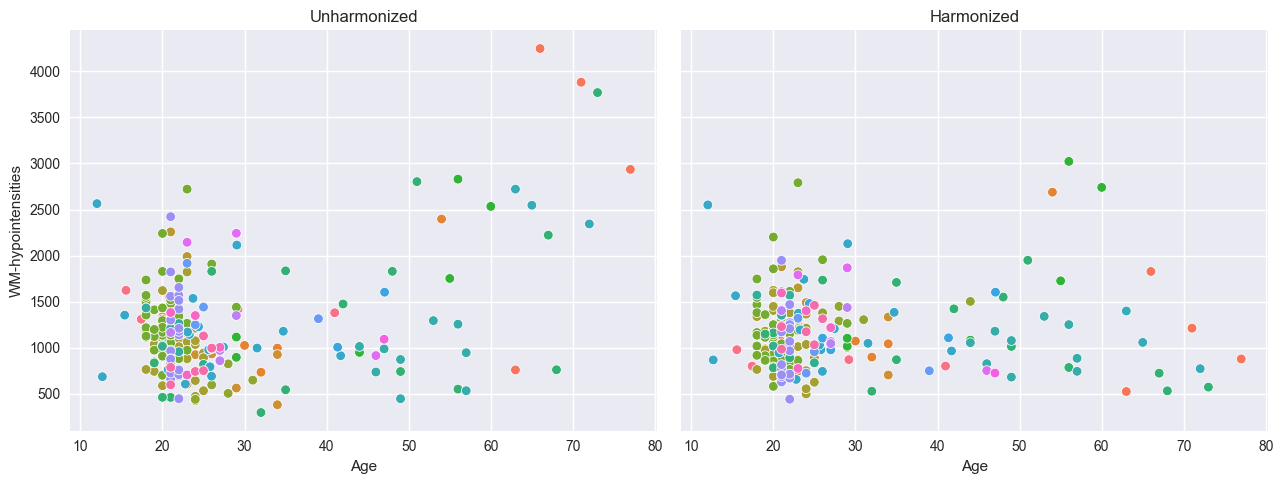

In [15]:
# Harmonizing is also easy:
reference_batch_effect = {
    "site": "Beijing_Zang",
    "sex": "M",
}  # Set a pseudo-batch effect. I.e., this means 'pretend that all data was from this site and sex'

model.harmonize(test, reference_batch_effect=reference_batch_effect)  # <- easy

plt.style.use("seaborn-v0_8")
df = test.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
sns.scatterplot(data=df, x=("X", "age"), y=("Y", feature_to_plot), hue=("batch_effects", "site"), ax=ax[0])
sns.scatterplot(data=df, x=("X", "age"), y=("Y_harmonized", feature_to_plot), hue=("batch_effects", "site"), ax=ax[1])
ax[0].title.set_text("Unharmonized")
ax[1].title.set_text("Harmonized")
ax[0].legend([], [])
ax[1].legend([], [])
ax[0].set_xlabel("Age")
ax[0].set_ylabel(feature_to_plot)
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)
plt.tight_layout()
plt.show()

### Synthesize

Our models can synthesize new data that follows the learned distribution. 

Not only the distribution of the response variables given a covariate is learned, but also the ranges of the covariates _within_ each batch effect. So if we have fitted a model on a number of sites, and subjects from A have an age between 10 and 20, then the synthesized pseudo-subjects from site A will also have an age between 10 and 20.

Not only that, but we also sample the batch effects in the frequency of the batch effects in the original data. So if the train data contained twice as many subjects from site A as site B, then the synthesized pseudo-subjects will also have twice as many subjects from site A as site B.

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 64750 - 2025-06-23 16:04:14 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


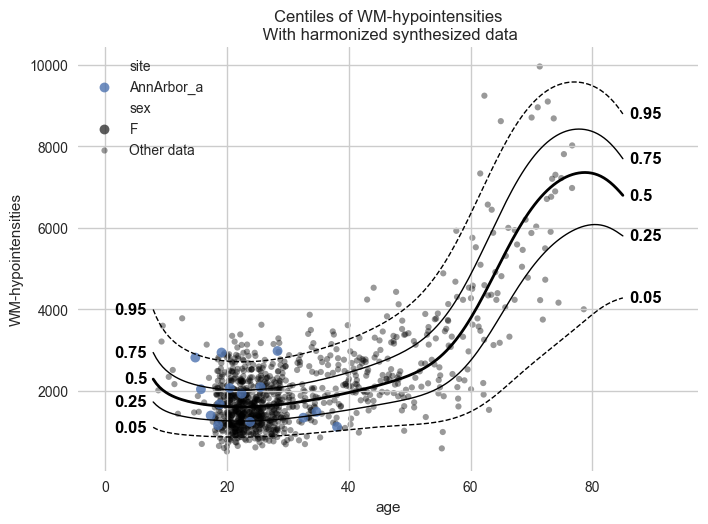

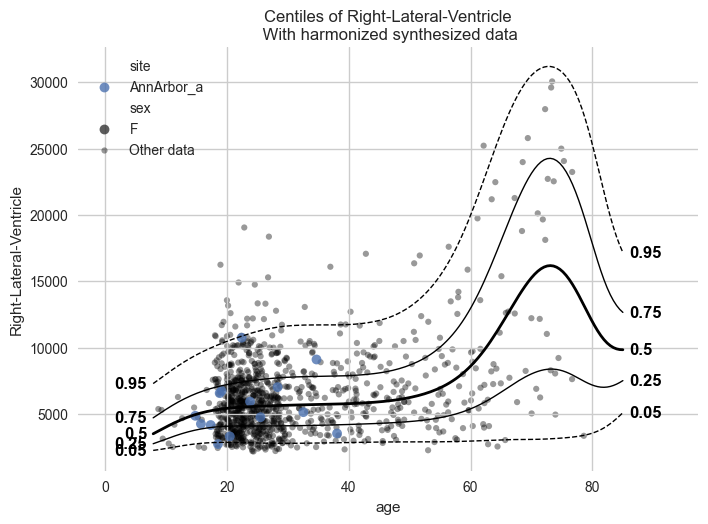

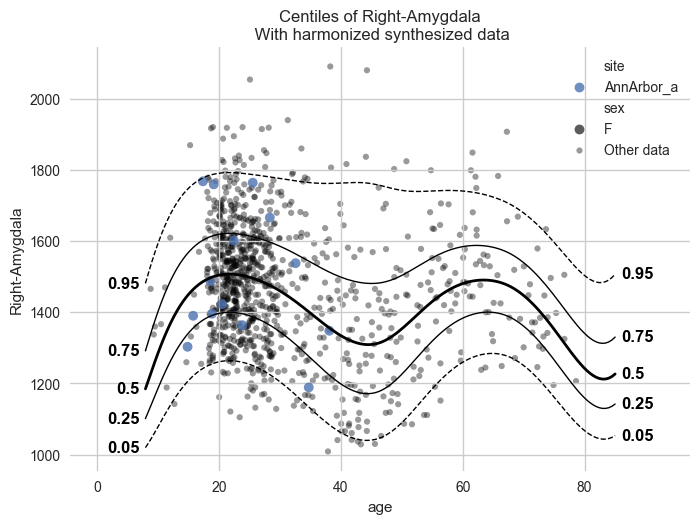

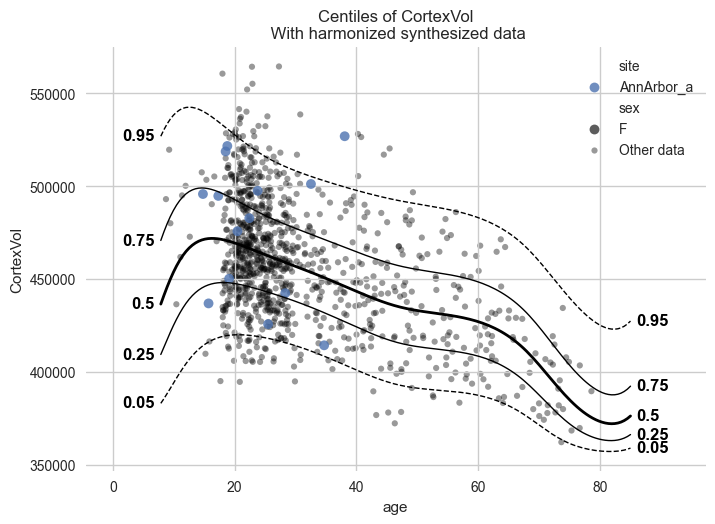

In [17]:
# Generate 10000 synthetic datapoints from scratch
synthetic_data = model.synthesize(covariate_range_per_batch_effect=True, n_samples=1000)  # <- also easy
# Show the synthetic data along with the centiles
plot_centiles(
    model,
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=synthetic_data,
    show_other_data=True,
    harmonize_data=True,
    show_legend=True,
)


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 64750 - 2025-06-23 16:05:58 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


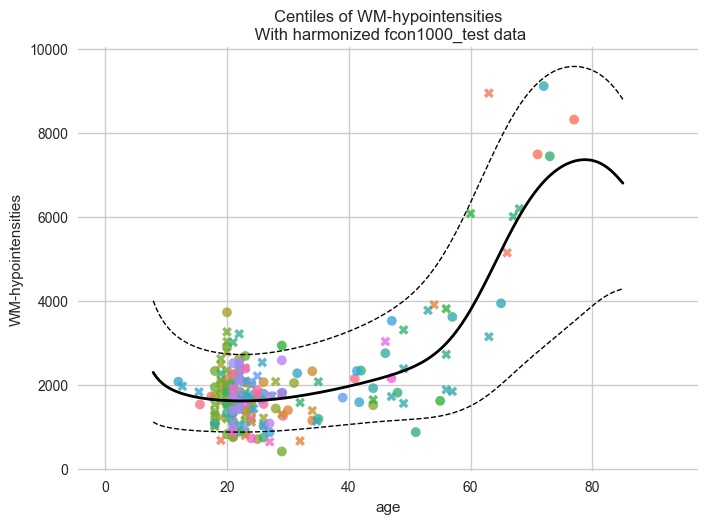

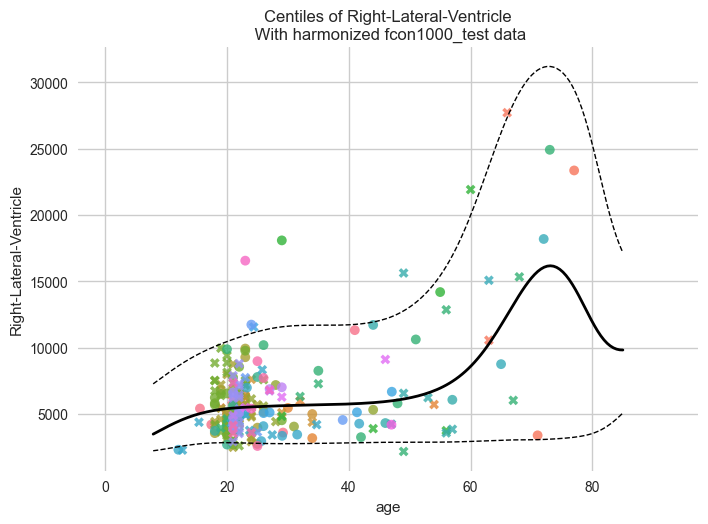

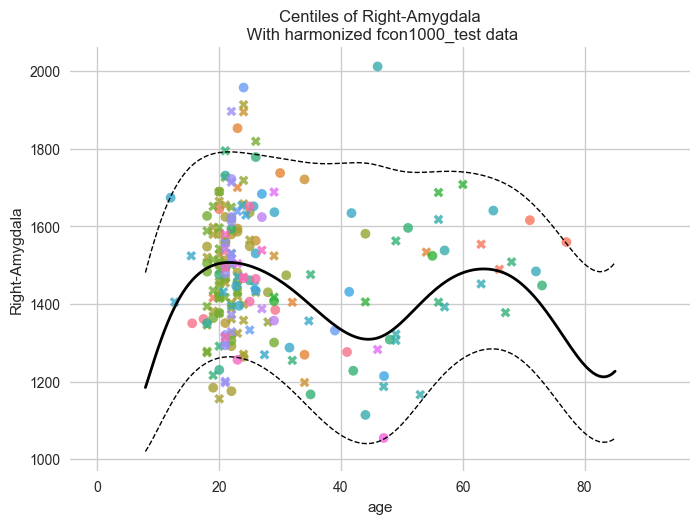

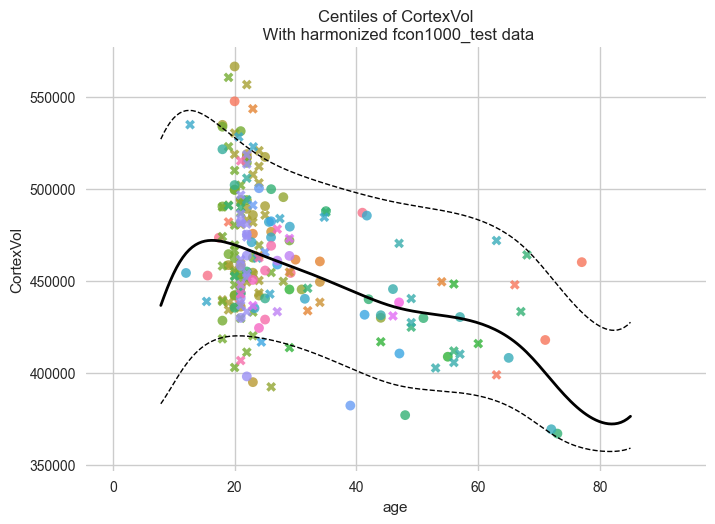

In [19]:
# Synthesize new Y data for existing X data
new_test_data = test.copy()

# Remove the Y data, this way we will synthesize new Y data for the existing X data
if hasattr(new_test_data, "Y"):
    del new_test_data["Y"]

synthetic = model.synthesize(new_test_data)  # <- will fill in the missing Y data
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot arbitrary centiles
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=synthetic,  # Scatter the train data points
    batch_effects="all",  # You can set this to "all" to show all batch effects
    show_other_data=True,  # Show data points that do not match any batch effects
    show_centile_labels=False,
    harmonize_data=True,  # Set this to False to see the difference
    show_legend=False,  # Don't show the legend because it crowds the plot
)

## Next steps

Please see the other tutorials for more examples, and we also recommend you to read the documentation! As this toolkit is still in development, the documentation may not be up to date. If you find any issues, please let us know! 

Also, feel free to contact us on Github if you have any questions or suggestions.

Have fun modeling!

### Bonus content

Here are some more HBR model configuration examples. You can replace the `template_hbr` that we used in the example with any of these. 

In [ ]:
# The beta likelihood is a bit different from the other likelihoods, it assumes the response variable is bounded between 0 and 1. The means that we have to apply a min max scaling to the response variable before fitting the model. Luckily, this is built into the PCNtoolkit, we just have to set 'outscaler' to 'minmax' in the `NormativeModel` constructor.

# The beta likelihood takes two parameters, alpha and beta. Intuitively, these encode 'pseudo-counts'.
# alpha=2, beta=4 encodes a distribution with a weak peak at 1/3.
# alpha=4, beta=8 encodes a distribution with a stronger peak at 1/3.
# alpha=20, beta=40 encodes a distribution with a very strong peak at 1/3.

# Alpha and beta both need to be strictly positive, so we either have to sample them from a positive distribution, or apply a mapping.


# Pick any of these three models for alpha and beta

# A very simple model where alpha and beta are both constant
alpha = make_prior(
    dist_name="Gamma",
    dist_params=(3.0, 1.0),
)
beta = make_prior(
    dist_name="Gamma",
    dist_params=(3.0, 1.0),
)

# A model where alpha and beta are both linear functions of the covariates
alpha = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(10.0, 3.0)),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
beta = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(10.0, 3.0)),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)


beta_likelihood = BetaLikelihood(alpha, beta)

beta_HBR_model = HBR(
    name="beta_HBR_model",
    likelihood=beta_likelihood,
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
)
